<span style="font-size:3em">How to predict with missing values in Python ?</span> 


Missing values occur in many applications of supervised learning. In this notebook, we will cover how to accurately predict the response `y` given `X` when `X` contains missing values (missing values in both training and testing data). 

In this case, there are essentially two approaches:
1. `Two-step strategy`: imputing missing data and applying classical methods on the completed data sets to predict;
2. `One-step strategy`: Predicting with methods adapted to the missing data without necessarily imputing them.
 
We first describe the methods on synthetic data and apply them on real datasets.

# Description of the different strategies

In [1]:
!pip install wget 

import numpy as np
import pandas as pd
import wget
import matplotlib.pyplot as plt
%matplotlib inline

wget.download('https://raw.githubusercontent.com/R-miss-tastic/website/master/static/how-to/python/produceNA.py')
wget.download('https://raw.githubusercontent.com/R-miss-tastic/website/master/static/how-to/python/tools.py')

from produceNA import *

from tools import color_imputedvalues_orange

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score

from sklearn.datasets import fetch_california_housing

In [2]:
np.random.seed(0)  # fix the seed 

n = 1000
p = 3

mean = np.repeat(0, p)
cov = 0.5 * (np.ones((p,p)) + np.eye(p))
x_comp = np.random.multivariate_normal(mean, cov, size = n)
b = np.random.uniform(low = 0, high = 3, size = p)
sigma_eps = 0.25
eps = np.random.normal(scale = sigma_eps, size = n)
y = x_comp.dot(b) + eps

We introduce some missing (here MCAR) values in the data matrix using the function `produce_NA` given in the Python Notebook [How to generate missing values in Python ?](https://rmisstastic.netlify.app/how-to/python/generate_html/how%20to%20generate%20missing%20values). 

In [3]:
p = 0.3 #30% of Missing Values

XproduceNA =  produce_NA(x_comp, p_miss=p, mecha="MCAR") #True for missing values, false for others
X_miss = XproduceNA['X_incomp']
x_miss = X_miss.numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_miss)) / x_miss.size,1), '%')

Ratio nan in X: 30.3 %


In [4]:
pd.DataFrame(x_miss).head().style.highlight_null(null_color='orange')

,0,1,2
0,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787
2,nan,nan,nan
3,0.504373,-0.827087,-0.683043
4,nan,-0.810354,-0.688679


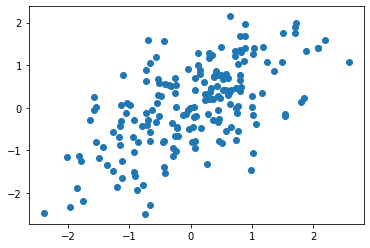

In [5]:
plt.scatter(x_miss[:400,0], x_miss[:400,1]);  #  data with missing coordinate are not plotted

## Two-steps strategy

We will consider two imputation methods:
* `Mean imputation`: replace missing values by the mean of the feature (the column);
* `Iterative imputation`: each feature is regressed/estimated from the others, which implies that imputation can take advantage of others features. 

More details on these methods can be found in [How to impute missing values in Python](https://rmisstastic.netlify.app/how-to/python/howtoimpute). 

Note that [Josse et al.](https://hal.archives-ouvertes.fr/hal-02024202v3/document) study the classic tools of missing values in the context of supervised learning. More particularly, they give the following take-home messages:

* If we possess a good learner algorithm and enough samples in our dataset (e.g. more than $10^5$), the mean imputation is a good default choice (since it is consistent). 
* It is important to use the same imputation for the train and the test set, since, in this case, the learning algorithm can learn the imputed value for detecting that the entry was initially missing.
* It might by fruitfull to add the missing values indicator (by concatenating the missing values indicator to `X`), in particular when missingness can be related to the prediction target (MNAR or MAR values).

In [6]:
## Mean imputation
x_mean = SimpleImputer().fit_transform(x_miss)
pd.DataFrame(x_mean).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2
0,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787
2,-0.004322,0.050350,-0.017309
3,0.504373,-0.827087,-0.683043
4,-0.004322,-0.810354,-0.688679


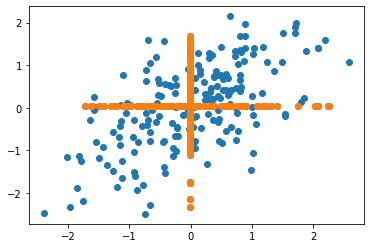

In [7]:
plt.scatter(x_mean[:400,0], x_mean[:400,1])

missing_mask = np.where([any(x) for x in np.isnan(x_miss[:400][:,[0,1]])])
plt.scatter(x_mean[missing_mask,0], x_mean[missing_mask,1])

To concatenate the missing indicator to `X`, we can use the argument `add_indicator=True` of SimpleImputer. Note that this concatenation is done after imputation and is only used for prediction.

In [8]:
## Mean imputation, return with indicator
x_mean_with_indicator = SimpleImputer(add_indicator=True).fit_transform(x_miss)
pd.DataFrame(x_mean_with_indicator).head().style.applymap(color_imputedvalues_orange, x_miss=np.concatenate((x_miss,np.isnan(x_miss)*1),axis=1))

,0,1,2,3,4,5
0,-0.875268,-1.922959,-1.522801,0.000000,0.000000,0.000000
1,-2.393913,-2.481345,-0.613787,0.000000,0.000000,0.000000
2,-0.004322,0.050350,-0.017309,1.000000,1.000000,1.000000
3,0.504373,-0.827087,-0.683043,0.000000,0.000000,0.000000
4,-0.004322,-0.810354,-0.688679,1.000000,0.000000,0.000000


In [9]:
# Iterative imputation
x_ice = IterativeImputer().fit_transform(x_miss)
pd.DataFrame(x_ice).head().style.applymap(color_imputedvalues_orange, x_miss=x_miss)

,0,1,2
0,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787
2,0.000511,0.026082,-0.018145
3,0.504373,-0.827087,-0.683043
4,-0.637556,-0.810354,-0.688679


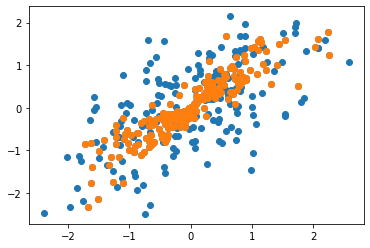

In [10]:
plt.scatter(x_ice[:400,0], x_ice[:400,1])

missing_mask = np.where([any(x) for x in np.isnan(x_miss[:400][:,[0,1]])])
plt.scatter(x_ice[missing_mask,0], x_ice[missing_mask,1])

In [11]:
## Iterative imputation, return with indicator
x_mice_with_indicator = IterativeImputer(add_indicator=True).fit_transform(x_miss)
pd.DataFrame(x_mice_with_indicator).head().style.applymap(color_imputedvalues_orange, x_miss=np.concatenate((x_miss,np.isnan(x_miss)*1),axis=1))

,0,1,2,3,4,5
0,-0.875268,-1.922959,-1.522801,0.000000,0.000000,0.000000
1,-2.393913,-2.481345,-0.613787,0.000000,0.000000,0.000000
2,0.000511,0.026082,-0.018145,1.000000,1.000000,1.000000
3,0.504373,-0.827087,-0.683043,0.000000,0.000000,0.000000
4,-0.637556,-0.810354,-0.688679,1.000000,0.000000,0.000000


## One-step strategy

We compare these imputations methods to a learning algorithm which can perform predictions by directly accounting for missing values:

* `MinMax Imputation (MIA)` (also refer as Missing In Attribute, by [Twala et al.](https://www.sciencedirect.com/science/article/pii/S0167865508000305)): duplicating features twice and replace its missing values once by $\infty$ and once by $- \infty$ (or extreme out-of-range values). Here, we choose to remplace them once by the maximum of the variable minus 1 and once by the minimum of the variable plus 1. More information on this method can be found in [Josse et al.](https://hal.archives-ouvertes.fr/hal-02024202v3/document).

This method does not pretend to impute missing data. Here, the step of duplicating features is internal in the learning algorithm and allows to create two dummy variables used for assigning missing values either to the left or the right interval. However, this approach of handling missing values can be seen as implicit imputation by an interval value.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin

class MinMaxImputer(BaseEstimator, TransformerMixin):
    # replacing the `nan` by two extremes values (by duplicating each column)
    
    def fit(self, X, y=None):
        mm = MinMaxScaler().fit(X)
        self.data_min_ = mm.data_min_
        self.data_max_ = mm.data_max_
        return self

    def transform(self, X):
        X_min, X_max = X.copy(), X.copy()

        for feature_idx in range(X.shape[1]):
            nan_mask = np.isnan(X[:, feature_idx])
            X_min[nan_mask, feature_idx] = self.data_min_[feature_idx] - 1
            X_max[nan_mask, feature_idx] = self.data_max_[feature_idx] + 1

        return np.concatenate([X_min, X_max], axis=1)

In [13]:
x_MIA = MinMaxImputer().fit_transform(x_miss)

In [14]:
pd.DataFrame(x_MIA).head().style.applymap(color_imputedvalues_orange, x_miss=np.concatenate((x_miss,np.isnan(x_miss)*1),axis=1))

,0,1,2,3,4,5
0,-0.875268,-1.922959,-1.522801,-0.875268,-1.922959,-1.522801
1,-2.393913,-2.481345,-0.613787,-2.393913,-2.481345,-0.613787
2,-3.973733,-3.906234,-4.032794,4.067673,4.167773,3.824628
3,0.504373,-0.827087,-0.683043,0.504373,-0.827087,-0.683043
4,-3.973733,-0.810354,-0.688679,4.067673,-0.810354,-0.688679


## Pipeline

Let's evaluate the different strategies. Let's consider our different imputers w.r.t. different machine learning algorithms. The pipeline will be 
1. Imputation.
2. Regression on the imputed dataset.

Here we decompose each step of the pipeline for clarity.

First, we can split the data intro train and test datasets. 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_miss, y)
print('train shape: X.shape={}, y.shape={}'.format(x_train.shape, y_train.shape))
print('test shape: X.shape={}, y.shape={}'.format(x_test.shape, y_test.shape))

train shape: X.shape=(750, 3), y.shape=(750,)
test shape: X.shape=(250, 3), y.shape=(250,)


We can then choose a learning algorithm, for exemple the ordinary least squares linear regression. We can use the class [sklearn.linear_model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) of scikit-learn. Note that we can not directly apply the regressor, since it can not deal with missing values. 

In [16]:
regressor = LinearRegression()

In [17]:
""" Line below would raise an ValueError: 
'Input contains NaN, infinity or a value too large for dtype('float64').'
Because LinearRegressor couldn't deal with NaN values.""";

# regressor.fit(X_train, y_train) 

We fit the model for imputing missing values in the train dataset and then transform both train and test with the *same* imputer.

In [18]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(x_train)

x_train_imp = imputer.transform(x_train)
x_test_imp = imputer.transform(x_test)

Finally, we can fit the regressor. 

In [19]:
regressor.fit(x_train_imp, y_train)
print('Score on train:', regressor.score(x_train_imp, y_train))
print('Score on test:', regressor.score(x_test_imp, y_test))

Score on train: 0.8023297760364352
Score on test: 0.8360819580218508


# Model selection on synthetic data

The function **plot_score_regressor** compares the strategies above (Mean imputation, Iterative imputation, MIA) in terms of prediction performances by applying them with chosen learning algorithms. The arguments are the following.

* `X`: data matrix containing missing values (covariates).
* `y`: output variable (containing no missing values).
* `regressor`: dictionnary containing the regressors to be performed for comparing strategies.

It returns Boxplot scores for each strategy.

In [20]:
def plot_score_regressor(X, y, regressor, regressor_name='regressor', X_complete=None):
    """
    Compare imputation methods (Mean imputation and Iterative imputation, with or without concatenating missing values indicator) 
    with the Missing In Attribute method in terms of prediction performance for chosen learning algorithms.
    
    
    Parameters
    ----------
    X : data matrix containing missing values.
    y : output variable (containing no missing values).
    regressor: dictionnary containing the regressors to be performed for comparing strategies.
    regressor_name: name for the regressors containing in regressor.
    X_complete: complete data matrix, required for computing scores.
    
    Returns
    -------
    Boxplot scores for each strategy.
    """
    
    imputers_wo_indicator = {'Simple': SimpleImputer(add_indicator=False),
                         'Iterative': IterativeImputer(add_indicator=False)}
    imputers_with_indicator = {'Simple': SimpleImputer(add_indicator=True),
                           'Iterative': IterativeImputer(add_indicator=True),
                           'MinMax': MinMaxImputer()}
    
    l_score = []
    for imputers in [imputers_wo_indicator, imputers_with_indicator]:
        for imputer_name, imputer in imputers.items():
            pipeline = Pipeline([(imputer_name, imputer), (regressor_name, regressor)])
            score = cross_val_score(pipeline, X, y, n_jobs=-1, cv = 5)
            l_score.append(score)
            
    score_ground_truth = cross_val_score(regressor, X_complete, y, n_jobs=-1, cv = 5)
    l_score.append(score_ground_truth)
    plt.title(regressor_name)     
    labels = ['Simple', 'Iterative', 'Simple+Mask', 'Iterative+Mask', 'MIA', 'X_complete']
    bplot = plt.boxplot(l_score[::-1], labels=labels[::-1],
                vert=False, patch_artist=True)

    # Add colors to boxplots
    for patch, color in zip(bplot['boxes'],
                            ['C0','C1','C2','C3', 'C4', 'C5']):
        patch.set_facecolor(color)

We apply this function by introducing MCAR or MNAR values in `X`.

In [21]:
## MCAR values
XproduceNA_MCAR =  produce_NA(x_comp, p_miss=p, mecha="MCAR") 
x_MCAR = XproduceNA_MCAR['X_incomp'].numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_MCAR)) / x_MCAR.size,1), '%')

Ratio nan in X: 29.5 %


In [22]:
pd.DataFrame(x_MCAR).head().style.highlight_null(null_color='orange')

,0,1,2
0,-0.875268,nan,nan
1,-2.393913,-2.481345,-0.613787
2,-0.835337,nan,-0.821626
3,0.504373,nan,-0.683043
4,-0.365120,nan,-0.688679


In [23]:
# MNAR values
XproduceNA_MNAR = produce_NA(x_comp, p_miss=p, mecha="MNAR", opt="selfmasked")
x_MNAR = XproduceNA_MNAR['X_incomp'].numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_MNAR)) / x_MNAR.size,1), '%')

Ratio nan in X: 30.4 %


In [24]:
pd.DataFrame(x_MNAR).head().style.highlight_null(null_color='orange')

,0,1,2
0,-0.875268,-1.922959,-1.522801
1,-2.393913,nan,nan
2,-0.835337,-0.670269,-0.821626
3,0.504373,nan,nan
4,-0.365120,-0.810354,nan


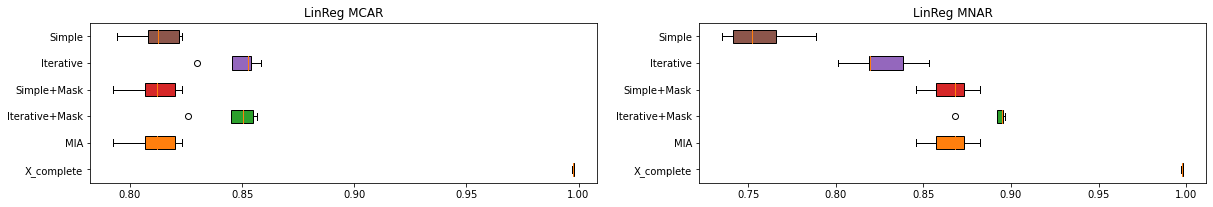

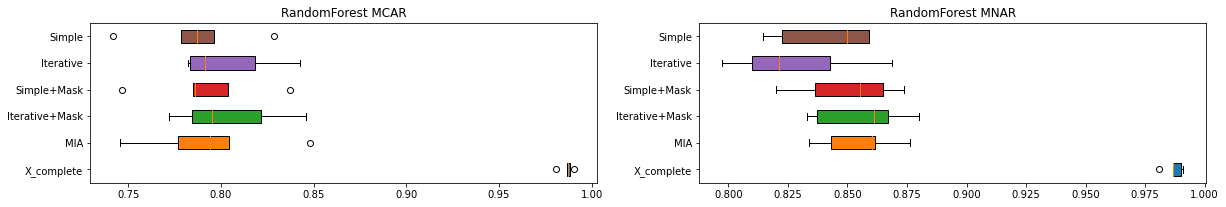

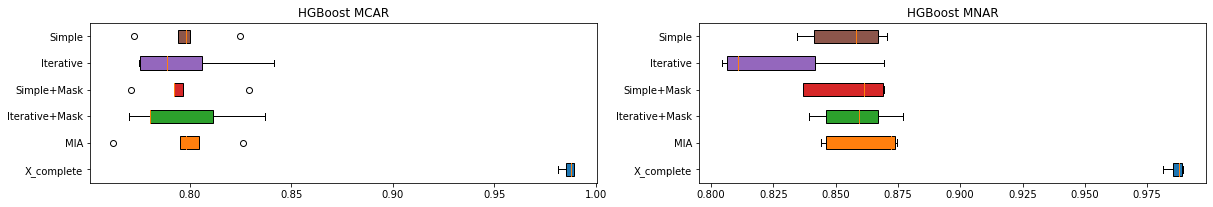

In [25]:
regressors = {'LinReg': LinearRegression(),
              'RandomForest': RandomForestRegressor(),
              "HGBoost": HistGradientBoostingRegressor()}

for regressor_name, regressor in regressors.items():
    plt.figure(figsize=(20,10))
    for ii, (X, X_name) in enumerate(zip([x_MCAR, x_MNAR], ['MCAR', 'MNAR'])):
        plt.subplot(3, 2, ii+1)
        plot_score_regressor(X, y, regressor, regressor_name + ' ' + X_name, x_comp)

# Model selection on real data

The function **plot_score_regressor** can also be used for real datasets in the wame way. Note that for computing scores, we must have access to the complete matrix.

In [26]:
x_comp, y = fetch_california_housing(return_X_y = True)

In [27]:
## MCAR values
XproduceNA_MCAR =  produce_NA(x_comp, p_miss=p, mecha="MCAR") 
x_MCAR = XproduceNA_MCAR['X_incomp'].numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_MCAR)) / x_MCAR.size,1), '%')

Ratio nan in X: 30.1 %


In [28]:
pd.DataFrame(x_MCAR).head().style.highlight_null(null_color='orange')

,0,1,2,3,4,5,6,7
0,8.325200,41.000000,6.984127,1.023810,nan,2.555556,nan,-122.230003
1,8.301400,21.000000,6.238137,nan,2401.000000,nan,37.860001,nan
2,7.257400,52.000000,nan,1.073446,nan,2.802260,37.849998,-122.239998
3,nan,52.000000,nan,1.073059,558.000000,2.547945,nan,-122.250000
4,3.846200,nan,6.281853,1.081081,nan,2.181467,nan,nan


In [29]:
# MNAR values
XproduceNA_MNAR = produce_NA(x_comp, p_miss=p, mecha="MNAR", opt="selfmasked")
x_MNAR = XproduceNA_MNAR['X_incomp'].numpy()
print('Ratio nan in X:', np.round(100 * np.sum(np.isnan(x_MNAR)) / x_MNAR.size,1), '%')

Ratio nan in X: 49.6 %


In [30]:
pd.DataFrame(x_MNAR).head().style.highlight_null(null_color='orange')

,0,1,2,3,4,5,6,7
0,8.325200,nan,6.984127,nan,nan,2.555556,nan,nan
1,8.301400,21.000000,nan,nan,2401.000000,2.109842,nan,nan
2,7.257400,nan,8.288136,nan,496.000000,2.802260,37.849998,nan
3,5.643100,nan,nan,nan,558.000000,2.547945,nan,nan
4,nan,nan,6.281853,1.081081,565.000000,2.181467,nan,nan


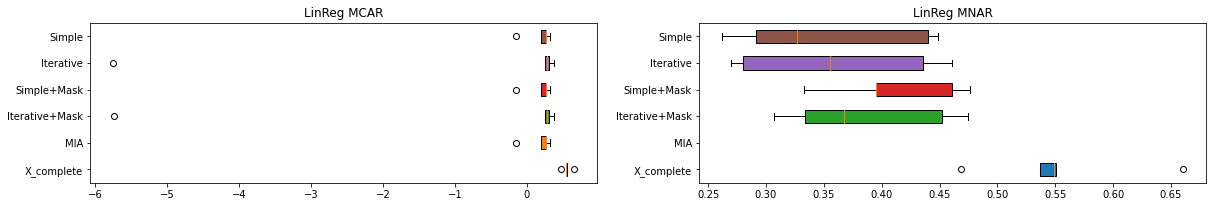

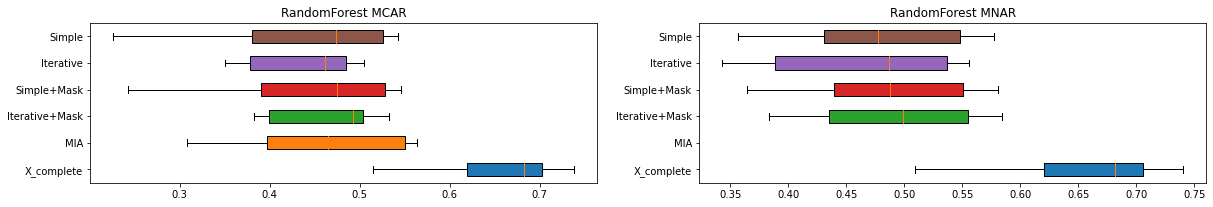

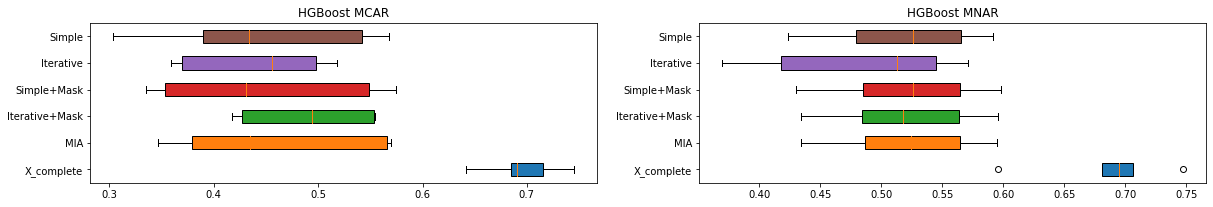

In [31]:
regressors = {'LinReg': LinearRegression(),
              'RandomForest': RandomForestRegressor(),
              "HGBoost": HistGradientBoostingRegressor()}

for regressor_name, regressor in regressors.items():
    plt.figure(figsize=(20,10))
    for ii, (X, X_name) in enumerate(zip([x_MCAR, x_MNAR], ['MCAR', 'MNAR'])):
        plt.subplot(3, 2, ii+1)
        plot_score_regressor(X, y, regressor, regressor_name + ' ' + X_name, x_comp)